# Non-Linear SVM using Digits Dataset

In [1]:
############ Compulsory Standard Library #################
import glob
import numpy as np
import matplotlib.pyplot as plt

############ Dataset ###################
# from sklearn.datasets import fetch_20newsgroups
from sklearn.datasets import load_digits

############ Utility Library #################
# from prettytable import PrettyTable
from termcolor import colored
import time
# import xlsxwriter
# import graphviz

############ Sklearn pre-processing Library #################
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, ShuffleSplit
from scipy.sparse import csr_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel

############ Sklearn model Library #################
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV

In [2]:
def extract_binary_digits(zero_class, one_class, data, target):
    data_indices = np.concatenate((np.argwhere(target == zero_class),np.argwhere(target == one_class))).flatten()
    X_data = data[data_indices, :]
    y_data = target[data_indices]
    
    if zero_class != 0 and one_class != 1:
        for i in range(0,len(y_data)):
            if y_data[i] == zero_class:
                y_data[i] = 0
            else:
                y_data[i] = 1
    return X_data, y_data

In [3]:
def svm_non_linear_predict(clf, X, gamma, top=True, top_k=2, threshold_value=0.1):
    rbf_kernel_matrix = rbf_kernel(X, clf.support_vectors_,gamma)
    dual_coef_dense_ = np.array(clf.dual_coef_).flatten()
    decision_function = np.full(X.shape[0], clf.intercept_)
    
    ''' Calculate the l*y*K() '''
    lambda_y_kernel = np.multiply(dual_coef_dense_, rbf_kernel_matrix)
    
    '''Sort the k-top support vectors'''
    neg_support_vectors_indices = np.argsort(lambda_y_kernel, axis=1)
    
    '''Calculate the decision function'''
    if top==True: 
        for i in range(0,X.shape[0]):
            for j in range(0, top_k):
                decision_function[i] = decision_function[i] + lambda_y_kernel[i,neg_support_vectors_indices[i,-(j+1)]] + lambda_y_kernel[i,neg_support_vectors_indices[i,j]]
        '''Assign y value'''
        y_predict = _predict(decision_function)
    else:
        
        for i in range(0,X.shape[0]):
            lambda_y_kernel_instance = lambda_y_kernel[i,:].flatten()
            decision_function[i] = decision_function[i] + np.sum(lambda_y_kernel_instance[np.absolute(lambda_y_kernel_instance) > threshold_value])
            del lambda_y_kernel_instance
        
        '''Assign y value'''
        y_predict = _predict(decision_function)
        
    
    return y_predict, decision_function, rbf_kernel_matrix, neg_support_vectors_indices

In [4]:
def _predict(decision_function):
    y_predict = np.zeros(len(decision_function))
    for i in range(0, len(decision_function)):
            if decision_function[i] < 0:
                y_predict[i] = 0
            else:
                y_predict[i] = 1
    return y_predict

### Loading Dataset

In [5]:
digits = load_digits()
X_data, y_data = extract_binary_digits(3, 5, digits.data, digits.target)

### Split Train and Test Data

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.33, random_state=42)

# X_train, X_test, y_train, y_test = train_test_split(
#     digits.data, digits.target, test_size=0.33, random_state=42)
print('# of Train Data : ', X_train.shape)
print('# of Test Data : ', X_test.shape)

# of Train Data :  (244, 64)
# of Test Data :  (121, 64)


### Fit data to the Model

### Prediction and Decision Function

In [7]:
################ FIT #######################
gamma_value = 0.001
clf = SVC(kernel='rbf', random_state=42,gamma=gamma_value)
clf.fit(X_train, y_train)

print(clf)
print("Fit End")

k = 2
y_predict, decision_test, rbf_kernel_matrix, support_vector_sorted = svm_non_linear_predict(clf, X_test, gamma_value, top_k=k)
print('Accuracy :', accuracy_score(y_predict, y_test))


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)
Fit End
Accuracy : 0.884297520661


### Accuracy Test

In [8]:
def svm_threshold_test():
    gamma_value = [0.01, 0.001, 0.0001]
    threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

    for i in gamma_value:
        clf = SVC(kernel='rbf', random_state=42,gamma=i)
        clf.fit(X_train, y_train)
        for j in threshold:
            y_predict, decision_test, rbf_kernel_matrix, support_vector_sorted = svm_non_linear_predict(clf, X_test, i, top=False, threshold_value=j)
            print(accuracy_score(y_predict, y_test))
            del y_predict
        del clf

In [9]:
def svm_top_k_test():
    gamma_value = [0.01, 0.001, 0.0001]
    
    for i in gamma_value:
        clf = SVC(kernel='rbf', random_state=42,gamma=i)
        clf.fit(X_train, y_train)
        for k in range(1,11):
            y_predict, decision_test, rbf_kernel_matrix, support_vector_sorted = svm_non_linear_predict(clf, X_test, i, top_k=k)
            print(accuracy_score(y_predict, y_test))
            del y_predict
        del clf

In [10]:
''' For accuracy test with given k and threshold '''

# svm_top_k_test()

' For accuracy test with given k and threshold '

## Evaluation
### Calculating Evidence and print the results

#### to image transform function

In [11]:
''' Transform 1D data to 2D for image visualization '''
def to_img_transform(data):
    img = np.zeros((8,8))
    for i in range(0,8):
        for j in range(0,8):
            img[i, j] = data[j+(i*8)]
    return img

In [12]:
''' Generate Positive and Negative Evidence Matrices '''
X_ev = np.multiply(np.array(clf.dual_coef_).flatten(), rbf_kernel_matrix)
pos_ev = X_ev * (X_ev > 0)
neg_ev = X_ev * (X_ev < 0)
object_pos_ev = np.zeros(X_ev.shape[0])
object_neg_ev = np.zeros(X_ev.shape[0])

for i in range(0,len(object_pos_ev)):
    for j in range(0,k):
        object_pos_ev[i] = object_pos_ev[i] + np.sum(pos_ev[i,support_vector_sorted[i,-(j+1)]])
        object_neg_ev[i] = object_neg_ev[i] + np.sum(neg_ev[i,support_vector_sorted[i,j]])


## Evaluation

In [26]:
def print_object_evidence(msg, 
                          clf, obj_idx,
                          decision_test, y_train, y_test, 
                          kernel_matrix, pos_ev, neg_ev, 
                          iter_range=1, top_k=1):
    dual_coef_flatten = np.array(clf.dual_coef_).flatten()
    kernel_obj = np.multiply(dual_coef_flatten, kernel_matrix[obj_idx, :])
    pos_list = np.argsort(kernel_obj)[::-1]
    neg_list = np.argsort(kernel_obj)
    
    
    print(msg)
    y_train[y_train == 0]=-1
    
    print()
    print('Class : ', y_test[obj_idx])
    print('Predict Class : ', y_predict[obj_idx])

    print('Object ID : ', obj_idx)
    print('Decision value provided by the clf :', decision_test[obj_idx])
    print('Difference between the original and modified Decision function : ', np.absolute(np.sum(kernel_obj)+clf.intercept_-decision_test[obj_idx]))
    print('intercept : ', clf.intercept_)
    print('Total Positive SV : ', clf.n_support_[0], ' Total Negative SV : ', clf.n_support_[1])
    print()
    
        
    print('Total positive Evidence:', np.sum(pos_ev[obj_idx,pos_list[:top_k]]))
    print('Total negative Evidence:', np.sum(neg_ev[obj_idx,neg_list[:top_k]]))
    
    print()
    print(top_k, 'Support Vector that contribute to the positive value')
    for i in range(0,top_k):
        print(' ', i+1, 
          'ID :',clf.support_[pos_list[i]], 
          '\t Lambda :', dual_coef_flatten[pos_list[i]]*y_train[clf.support_[pos_list[i]]],
          '\t Label : ', y_train[clf.support_[pos_list[i]]],
          ' K() :', kernel_matrix[obj_idx, pos_list[i]],
          '\t L*y*K():', kernel_obj[pos_list[i]])
    
    print()
    print(top_k, 'Support Vector that contribute to the negative value')   
    for i in range(0,top_k):
        print(' ', i+1, 
          'ID :',clf.support_[neg_list[i]], 
          '\t Lambda :', dual_coef_flatten[neg_list[i]]*y_train[clf.support_[neg_list[i]]],
          '\t Label : ', y_train[clf.support_[neg_list[i]]],
          ' K() :', kernel_matrix[obj_idx, neg_list[i]],
          '\t L*y*K():', kernel_obj[neg_list[i]])

    ''' Print target and support vector image'''
    plt.gray()
    plt.matshow(to_img_transform(X_test[obj_idx])) 
    plt.title(msg)
    
    if top_k == 1:
        plt.matshow(to_img_transform(X_train[clf.support_[pos_list[0]]]))
        plt.matshow(to_img_transform(X_train[clf.support_[neg_list[0]]]))
    else:
        f, (pos, neg) = plt.subplots(2, top_k, sharex='col', sharey='row')
        for i in range(0,top_k):
            pos[i].matshow(to_img_transform(X_train[clf.support_[pos_list[i]]]))
            neg[i].matshow(to_img_transform(X_train[clf.support_[neg_list[i]]]))
        f.subplots_adjust(hspace=0.3)
    
    
    plt.show()

### Randomly select false negative

RBF
Randomly selected False Negative

Class :  1
Predict Class :  0.0
Object ID :  5
Decision value provided by the clf : -0.0642402031086
Difference between the original and modified Decision function :  [ 0.36158994]
intercept :  [ 0.03036542]
Total Positive SV :  33  Total Negative SV :  42

Total positive Evidence: 0.686370510344
Total negative Evidence: -0.780976134279

2 Support Vector that contribute to the positive value
  1 ID : 223 	 Lambda : 1.0 	 Label :  1  K() : 0.345072755043 	 L*y*K(): 0.345072755043
  2 ID : 23 	 Lambda : 1.0 	 Label :  1  K() : 0.341297755301 	 L*y*K(): 0.341297755301

2 Support Vector that contribute to the negative value
  1 ID : 146 	 Lambda : 1.0 	 Label :  -1  K() : 0.513246008513 	 L*y*K(): -0.513246008513
  2 ID : 25 	 Lambda : 0.760502561402 	 Label :  -1  K() : 0.352043687102 	 L*y*K(): -0.267730125767


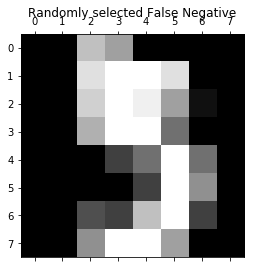

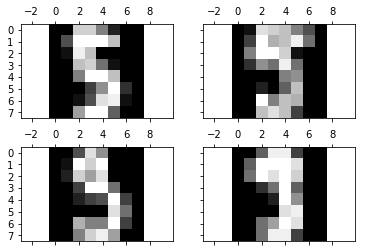

In [27]:
print('RBF')
obj = np.argwhere(y_test != y_predict).flatten()
print_object_evidence('Randomly selected False Negative', 
                      clf, obj[0], 
                      decision_test, y_train, y_test, rbf_kernel_matrix, 
                      pos_ev, neg_ev, top_k=k)

### The most positive object with respect to the decision_function

The support vector ID w.r.t to the original ID in the training dataset

RBF
Most Positive Object w.r.t Decision Function

Class :  1
Predict Class :  1.0
Object ID :  109
Decision value provided by the clf : 0.635576642594
Difference between the original and modified Decision function :  [ 0.18895413]
intercept :  [ 0.03036542]
Total Positive SV :  33  Total Negative SV :  42

Total positive Evidence: 1.00698276759
Total negative Evidence: -0.401771545822

2 Support Vector that contribute to the positive value
  1 ID : 234 	 Lambda : 0.680270703938 	 Label :  1  K() : 0.805735301873 	 L*y*K(): 0.548118120993
  2 ID : 222 	 Lambda : 1.0 	 Label :  1  K() : 0.458864646596 	 L*y*K(): 0.458864646596

2 Support Vector that contribute to the negative value
  1 ID : 146 	 Lambda : 1.0 	 Label :  -1  K() : 0.243899261901 	 L*y*K(): -0.243899261901
  2 ID : 110 	 Lambda : 0.605337634873 	 Label :  -1  K() : 0.260800377881 	 L*y*K(): -0.15787228392


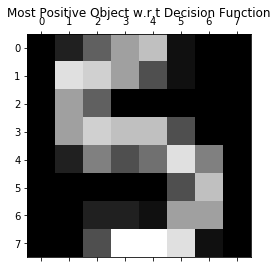

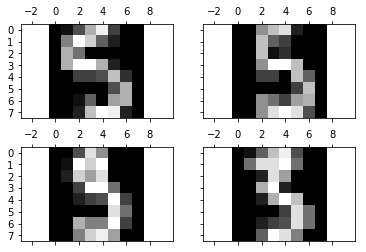

In [28]:
print('RBF')
pos_obj_idx = np.argmax(decision_test)
print_object_evidence('Most Positive Object w.r.t Decision Function', 
                      clf, pos_obj_idx,  
                      decision_test, y_train, y_test, rbf_kernel_matrix, 
                      pos_ev, neg_ev, top_k=k)

### The most negative object with respect to the decision_function

Cosine Similarity
Most Negative Object w.r.t Decision Function

Class :  0
Predict Class :  0.0
Object ID :  49
Decision value provided by the clf : -0.371917396297
Difference between the original and modified Decision function :  [ 0.35590786]
intercept :  [ 0.03036542]
Total Positive SV :  33  Total Negative SV :  42

Total positive Evidence: 0.69667476369
Total negative Evidence: -1.09895758081

2 Support Vector that contribute to the positive value
  1 ID : 222 	 Lambda : 1.0 	 Label :  1  K() : 0.435613454987 	 L*y*K(): 0.435613454987
  2 ID : 23 	 Lambda : 1.0 	 Label :  1  K() : 0.261061308703 	 L*y*K(): 0.261061308703

2 Support Vector that contribute to the negative value
  1 ID : 146 	 Lambda : 1.0 	 Label :  -1  K() : 0.737123374392 	 L*y*K(): -0.737123374392
  2 ID : 194 	 Lambda : 0.859358442365 	 Label :  -1  K() : 0.421051552627 	 L*y*K(): -0.361834206421


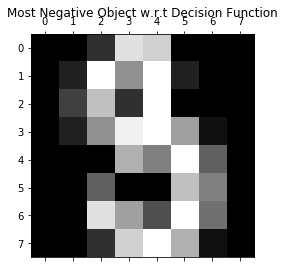

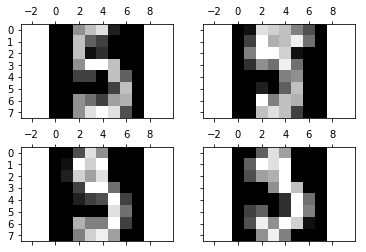

In [29]:
print('Cosine Similarity')

neg_obj_idx = np.argmin(decision_test)
print_object_evidence('Most Negative Object w.r.t Decision Function', 
                      clf, neg_obj_idx,  
                      decision_test, y_train, y_test, rbf_kernel_matrix,
                      pos_ev, neg_ev, top_k=k)

### Least Confidence Object

Cosine Similarity
Least Confidence Object w.r.t Decision Function

Class :  0
Predict Class :  0.0
Object ID :  92
Decision value provided by the clf : -0.000393951008195
Difference between the original and modified Decision function :  [ 1.33988542]
intercept :  [ 0.03036542]
Total Positive SV :  33  Total Negative SV :  42

Total positive Evidence: 0.572725316609
Total negative Evidence: -0.603484688444

1 Support Vector that contribute to the positive value
  1 ID : 222 	 Lambda : 1.0 	 Label :  1  K() : 0.376062472172 	 L*y*K(): 0.376062472172
  2 ID : 234 	 Lambda : 0.680270703938 	 Label :  1  K() : 0.289094978365 	 L*y*K(): 0.196662844437

1 Support Vector that contribute to the negative value
  1 ID : 146 	 Lambda : 1.0 	 Label :  -1  K() : 0.303613429576 	 L*y*K(): -0.303613429576
  2 ID : 186 	 Lambda : 0.509970685903 	 Label :  -1  K() : 0.588016658913 	 L*y*K(): -0.299871258868


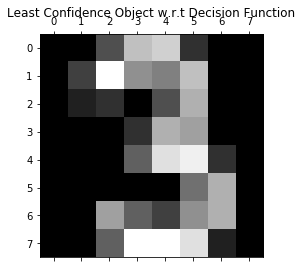

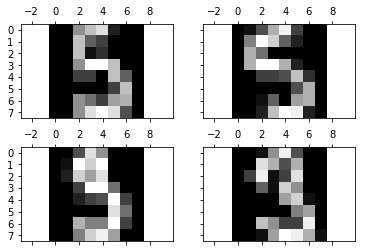

In [17]:
print('Cosine Similarity')

least_conf_obj_idx = np.argmin(np.absolute(decision_test))
print_object_evidence('Least Confidence Object w.r.t Decision Function', 
                      clf, least_conf_obj_idx, 
                      decision_test, y_train, y_test, rbf_kernel_matrix,
                     pos_ev, neg_ev, top_k=k)

### The most positive object w.r.t the positive evidence

Cosine Similarity
Most Positive Object w.r.t Positive Evidence

Class :  1
Predict Class :  1.0
Object ID :  95
Decision value provided by the clf : 0.572606472036
Difference between the original and modified Decision function :  [ 0.56414715]
intercept :  [ 0.03036542]
Total Positive SV :  33  Total Negative SV :  42

Total positive Evidence: 1.08588257322
Total negative Evidence: -0.543641522012

2 Support Vector that contribute to the positive value
  1 ID : 23 	 Lambda : 1.0 	 Label :  1  K() : 0.692117181689 	 L*y*K(): 0.692117181689
  2 ID : 66 	 Lambda : 1.0 	 Label :  1  K() : 0.393765391532 	 L*y*K(): 0.393765391532

2 Support Vector that contribute to the negative value
  1 ID : 146 	 Lambda : 1.0 	 Label :  -1  K() : 0.282521676603 	 L*y*K(): -0.282521676603
  2 ID : 25 	 Lambda : 0.760502561402 	 Label :  -1  K() : 0.343351697498 	 L*y*K(): -0.261119845409


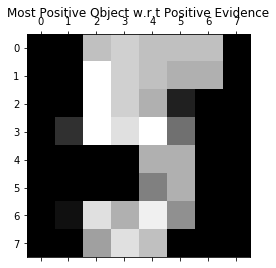

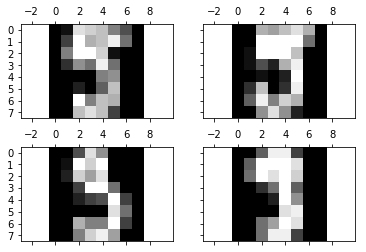

In [30]:
print('Cosine Similarity')
pos_ev_obj_idx = np.argmax(object_pos_ev)
print_object_evidence('Most Positive Object w.r.t Positive Evidence', 
                      clf, pos_ev_obj_idx, 
                      decision_test, y_train, y_test, rbf_kernel_matrix,
                      pos_ev, neg_ev, top_k=k)

### The most negative object w.r.t the negative evidence

Cosine Similarity
Most Negative Object w.r.t Negative Evidence

Class :  0
Predict Class :  0.0
Object ID :  49
Decision value provided by the clf : -0.371917396297
Difference between the original and modified Decision function :  [ 0.35590786]
intercept :  [ 0.03036542]
Total Positive SV :  33  Total Negative SV :  42

Total positive Evidence: 0.69667476369
Total negative Evidence: -1.09895758081

2 Support Vector that contribute to the positive value
  1 ID : 222 	 Lambda : 1.0 	 Label :  1  K() : 0.435613454987 	 L*y*K(): 0.435613454987
  2 ID : 23 	 Lambda : 1.0 	 Label :  1  K() : 0.261061308703 	 L*y*K(): 0.261061308703

2 Support Vector that contribute to the negative value
  1 ID : 146 	 Lambda : 1.0 	 Label :  -1  K() : 0.737123374392 	 L*y*K(): -0.737123374392
  2 ID : 194 	 Lambda : 0.859358442365 	 Label :  -1  K() : 0.421051552627 	 L*y*K(): -0.361834206421


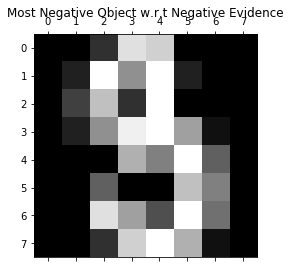

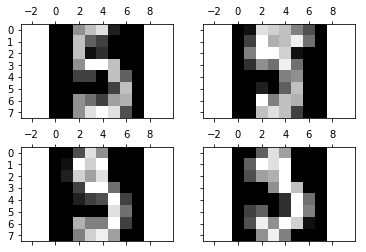

In [31]:
print('Cosine Similarity')
neg_ev_obj_idx = np.argmin(object_neg_ev)
print_object_evidence('Most Negative Object w.r.t Negative Evidence', 
                      clf, neg_ev_obj_idx,  
                      decision_test, y_train, y_test, rbf_kernel_matrix,
                     pos_ev, neg_ev, top_k=k)

### Subset of Total Evidence

In [20]:
total_evidence = object_neg_ev + object_pos_ev
n_samples = total_evidence.shape[0]
total_ev_indices_ = np.argsort(total_evidence)[::-1]

# print(np.sum(total_evidence > 0))
# print(np.sum(total_evidence < 0))
print()
print(n_samples)
upper_threshold = np.int_(np.ceil(n_samples * 0.2))
print(upper_threshold)

lower_threshold = np.int_(np.floor(n_samples * 0.8))
print(lower_threshold)

print()
upper_subset = total_ev_indices_[:upper_threshold]
lower_subset = total_ev_indices_[lower_threshold:]
print(upper_subset.shape)
print(lower_subset.shape)
print()

min_neg_ev_in_pos_S = np.argmin(np.absolute(object_neg_ev[upper_subset]))
min_pos_ev_in_neg_S = np.argmin(object_pos_ev[lower_subset])

print(upper_subset[min_neg_ev_in_pos_S])
# for i in range(0,upper_subset.shape[0]):
#     print(decision_test[upper_subset[i]])


121
25
96

(25,)
(25,)

41


Cosine Similarity
Positive Object which contains Minimum Negative Evidence (abs)

Class :  1
Predict Class :  1.0
Object ID :  41
Decision value provided by the clf : 0.296122842174
Difference between the original and modified Decision function :  [ 0.60362202]
intercept :  [ 0.03036542]
Total Positive SV :  33  Total Negative SV :  42

Total positive Evidence: 0.402041497714
Total negative Evidence: -0.136284076366

1 Support Vector that contribute to the positive value
  1 ID : 225 	 Lambda : 0.393675867856 	 Label :  1  K() : 0.578683258684 	 L*y*K(): 0.227813634076
  2 ID : 47 	 Lambda : 0.648306775704 	 Label :  1  K() : 0.268742931844 	 L*y*K(): 0.174227863637

1 Support Vector that contribute to the negative value
  1 ID : 107 	 Lambda : 0.816270222211 	 Label :  -1  K() : 0.0891887828595 	 L*y*K(): -0.0728021476035
  2 ID : 79 	 Lambda : 1.0 	 Label :  -1  K() : 0.0634819287627 	 L*y*K(): -0.0634819287627


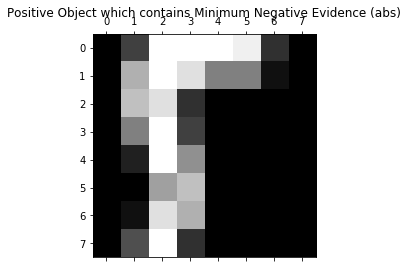

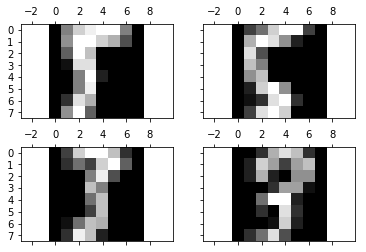

In [21]:
print('Cosine Similarity')
print_object_evidence('Positive Object which contains Minimum Negative Evidence (abs)', 
                      clf, upper_subset[min_neg_ev_in_pos_S],  
                      decision_test, y_train, y_test, rbf_kernel_matrix,
                     pos_ev, neg_ev, top_k=k)

Cosine Similarity
Negative Object which contains Minimum Positive Evidence

Class :  0
Predict Class :  0.0
Object ID :  2
Decision value provided by the clf : -0.233468131778
Difference between the original and modified Decision function :  [ 0.94159004]
intercept :  [ 0.03036542]
Total Positive SV :  33  Total Negative SV :  42

Total positive Evidence: 0.319332049576
Total negative Evidence: -0.583165602181

1 Support Vector that contribute to the positive value
  1 ID : 23 	 Lambda : 1.0 	 Label :  1  K() : 0.169314050763 	 L*y*K(): 0.169314050763
  2 ID : 223 	 Lambda : 1.0 	 Label :  1  K() : 0.150017998813 	 L*y*K(): 0.150017998813

1 Support Vector that contribute to the negative value
  1 ID : 79 	 Lambda : 1.0 	 Label :  -1  K() : 0.362040208543 	 L*y*K(): -0.362040208543
  2 ID : 197 	 Lambda : 0.392575915041 	 Label :  -1  K() : 0.563267855122 	 L*y*K(): -0.221125393638


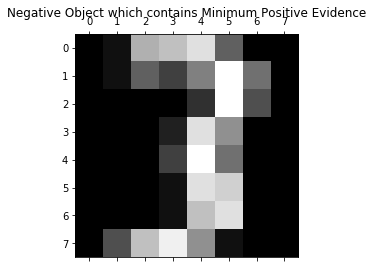

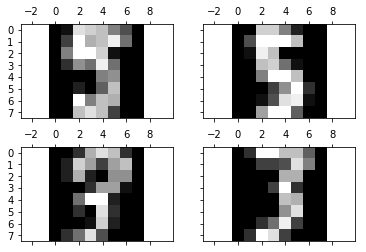

In [22]:
print('Cosine Similarity')
print_object_evidence('Negative Object which contains Minimum Positive Evidence', 
                      clf, lower_subset[min_pos_ev_in_neg_S],  
                      decision_test, y_train, y_test, rbf_kernel_matrix,
                     pos_ev, neg_ev, top_k=k)
